# General Import 

In [18]:
%matplotlib inline
import healpy as hp
from scipy.stats import norm
import matplotlib.mlab as mlab
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
import sys
import os
import MagTheo as mt
import funcSNm2 as f
reload(f)
reload(mt)

# Disable Printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore Printing
def enablePrint():
    sys.stdout = nb_stdout

pi = np.pi

In [2]:
#Data Input
##(columns: z, mag, dmag, l, b, mag^th)
OPSD = np.loadtxt('ordered_PS_data.txt')
z = OPSD[:,0]
m_i = OPSD[:,1]
sig_i = OPSD[:,2]
l_gal =  OPSD[:,3]
b_gal = OPSD[:,4]
m_th_d = OPSD[:,5]

#galactic coordinates -> angles
theta = np.zeros(np.size(l_gal))
phi = np.zeros(np.size(l_gal))
for i in range(np.size(l_gal)):
    phi[i] = l_gal[i]*pi/180
    theta[i] = pi/2 - b_gal[i]*pi/180
    
## Importing Noise and Signal Matricies
noise = np.loadtxt(open('Noise.csv'), delimiter=",")
signal = np.loadtxt(open('Signal.csv'), delimiter=',')
cov = noise + signal

# Generating New Theoretical Data 
## Conditionally splicing data

870


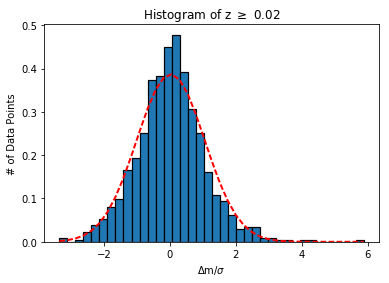

monopole: 0.124542


In [19]:
resd = (m_i - m_th_d) / sig_i
cond = [z > 0]
z_cond = z[cond]
m_i_cond = m_i[cond]
sig_i_cond = sig_i[cond]
indicies = np.arange(len(m_i))
keep = np.copy(indicies[cond])
inkeep = []

for i in range(len(keep)):
    if (keep[i] <= len(cov) - 1):
        inkeep.append(keep[i])
        

cov_cond = f.shift_cov(inkeep, cov)

arr = np.array(resd[cond])
print len(arr)

(mu, sigma) = norm.fit(arr)
n, bins, patches = plt.hist(arr, bins='auto', edgecolor='black', linewidth=1.2, normed=True)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.title("Histogram of z $\geq$ 0.02")
plt.xlabel("$\Delta$m/$\sigma$")
plt.ylabel("# of Data Points")
plt.savefig('histo002.png')
plt.show()

resrPix = f.pixres(16, theta[cond], phi[cond], resd[cond])
resrPix = hp.remove_monopole(resrPix)
clc = hp.anafast(resrPix)
ellc = np.arange(len(clc))

dA = hp.nside2pixarea(16)
omg_sky = 4*pi - dA*np.count_nonzero(resrPix == hp.UNSEEN)
cnor16 = (4*pi/omg_sky)

## Actually Generating new m_th

In [20]:
#Tabulation Schematics
step_num = 20000
dx = np.max(z_cond) / step_num
x = np.linspace(0, np.max(z_cond), step_num)

#Matching z_i to the tabulated values
tab_value = mt.match(x, z_cond, dx)

In [21]:
#Initalizing Variables
N = 300
omega_m = np.linspace(0.1, 1, N)
m_th = np.zeros(len(m_i_cond))
cov_inv = np.linalg.inv(cov_cond)

#Script M Stuff
d_script_M = 0.001
script_M = np.arange(43.1,43.6,d_script_M)      

Starting...
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
3

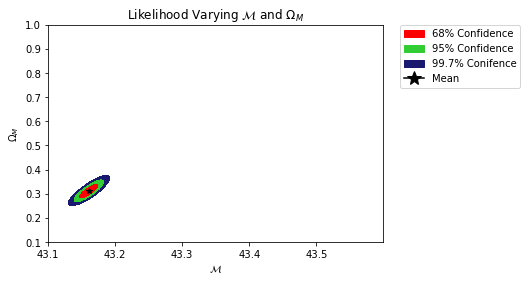

In [22]:
reload(mt)
## Integrating to find m_th, and compare to m to find most likely config
L_hood = np.zeros((N,len(script_M)))
L_hood_max = 0
print "Starting..."

for i in range(N):
    print (N - i)
    H_0dL = mt.d_L(z_cond, omega_m[i], tab_value, x)
    m_th = mt.m_theory(H_0dL)
        
    for j in range(len(script_M)):
            m_th_new = m_th + script_M[j]
            X_squared = mt.chi(m_i_cond, m_th_new, sig_i_cond, cov_inv)
            L_hood[i][j] = mt.likelihood(X_squared, 500)
            
            if (L_hood[i][j] > L_hood_max):
                m_th_final = np.copy(m_th_new)
                script_m_final = script_M[j]
                omega_m_final = omega_m[i]
                L_hood_max = L_hood[i][j]
            
print "Finished!"

mt.graphnmean(L_hood, script_M, omega_m, "$\mathcal{M}$", "$\Omega_M$")

In [23]:
m_th_cond = mt.m_theory(mt.d_L(z_cond, omega_m_final, tab_value, x)) + script_m_final

resd_cond = (m_i_cond - m_th_cond) / sig_i_cond

## Spectrum analysis with the new shit

In [24]:
elld16mi, cld16mi, ells16mi, cls16mi, err16mi, nor16m = f.powspec(16, 
            theta[cond], phi[cond], resd_cond, remove_monopole=True)

Number of SN Used: 870.0
done


In [25]:
## Normalizations ##

elld16m = np.copy(elld16mi)
cld16m = 4*8*np.copy(cld16mi)*nor16m
ells16m = np.copy(ells16mi)
cls16m = 4*8*np.copy(cls16mi)*nor16m
err16m = 4*8*np.copy(err16mi)*nor16m

clc16 = 4*8*np.copy(clc)*cnor16
ellc16 = ellc

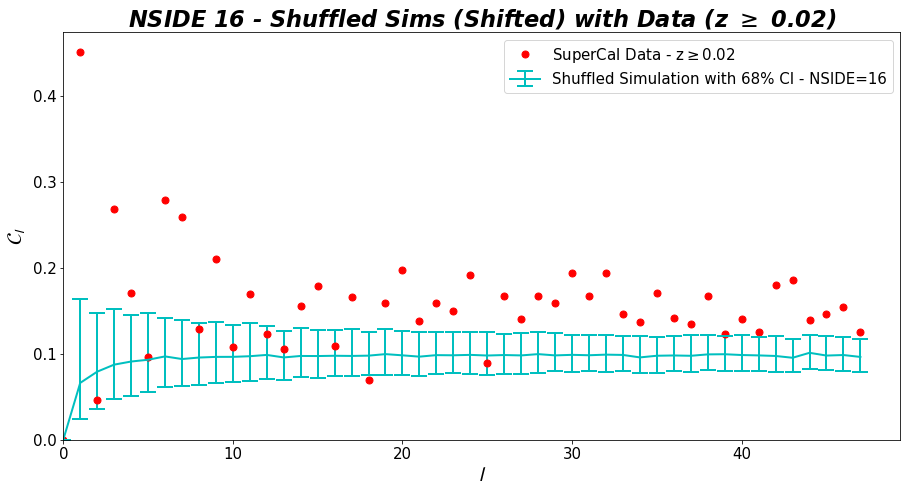

data:
354.572678197
7.5440995361


In [26]:
plt.figure(figsize=(15,7.5))
#NSIDE=16
plt.plot(elld16m, cld16m, 'ko', color='r', label='SuperCal Data - z$\geq$0.02', ms=7)

plt.errorbar(ells16m, cls16m, yerr= err16m,
            fmt='-', ecolor='c', capsize=8, capthick=2, elinewidth=2, linewidth=2,
            color='c', label='Shuffled Simulation with 68% CI - NSIDE=16')


plt.xlabel('$\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.ylabel('$\mathcal{C}_\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.title('NSIDE 16 - Shuffled Sims (Shifted) with Data (z $\geq$ 0.02)', 
          fontsize=22.5, style='italic', weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis(xmin=0, ymin=0)
plt.legend(loc='upper right', numpoints=1, fontsize=15)

plt.show()

ch16 = f.chi_sq(np.array(cld16m), np.array(cls16m), np.array(err16m))

print "data:"
print ch16
print ch16/max(elld16m)

# Spectrum Analysis with the full data, including their theory

## Using $\sigma = \frac {1} {\sqrt{C^{-1}}}$ Diagonals

In [45]:
#making our residual metric (FULL SET)
delm = m_i - m_th_d
resd_inv = np.zeros(np.size(m_i))
cov_inv = np.linalg.inv(cov)

for i in range(np.size(cov_inv[0])):
    resd_inv[i] = delm[i]*np.sqrt(cov_inv[i][i]) 
for i in range(np.size(cov_inv[0]), np.size(m_i)):
    resd_inv[i] = delm[i]/sig_i[i]
    
elld16i, cld16i, ells16i, cls16i, err16i, nor16 = f.powspec(16, 
            theta, phi, resd_inv, remove_monopole=False)

elld_inv = np.copy(elld16i)
cld_inv = 4*8*np.copy(cld16i)*nor16
ells_inv = np.copy(ells16i)
cls_inv = 4*8*np.copy(cls16i)*nor16
err_inv = 4*8*np.copy(err16i)*nor16


Number of SN Used: 870.0
done


## Using $\sigma = \sqrt{C}$ diagonals

In [33]:
#making our residual metric (FULL SET)
delm = m_i - m_th_d
resd_cov = np.zeros(np.size(m_i))
cov_inv = np.linalg.inv(cov)

for i in range(np.size(cov_inv[0])):
    resd_cov[i] = delm[i]/np.sqrt(cov[i][i])
for i in range(np.size(cov_inv[0]), np.size(m_i)):
    resd_cov[i] = delm[i]/sig_i[i]
    
elld16i, cld16i, ells16i, cls16i, err16i, nor16 = f.powspec(16, 
            theta, phi, resd_cov, remove_monopole=True)

elld_cov = np.copy(elld16i)
cld_cov = 4*8*np.copy(cld16i)*nor16
ells_cov = np.copy(ells16i)
cls_cov = 4*8*np.copy(cls16i)*nor16
err_cov = 4*8*np.copy(err16i)*nor16


Number of SN Used: 870.0
done


## Using Plain $\sigma$

In [47]:
#making our residual metric (FULL SET)
delm = m_i - m_th_d
resd_cov = np.zeros(np.size(m_i))
cov_inv = np.linalg.inv(cov)

for i in range(np.size(m_i)):
    resd_cov[i] = delm[i]/sig_i[i]
    
elld16i, cld16i, ells16i, cls16i, err16i, nor16 = f.powspec(16, 
            theta, phi, resd_cov, remove_monopole=True)

elld_nor = np.copy(elld16i)
cld_nor = 4*8*np.copy(cld16i)*nor16
ells_nor = np.copy(ells16i)
cls_nor = 4*8*np.copy(cls16i)*nor16
err_nor = 4*8*np.copy(err16i)*nor16

Number of SN Used: 870.0
done


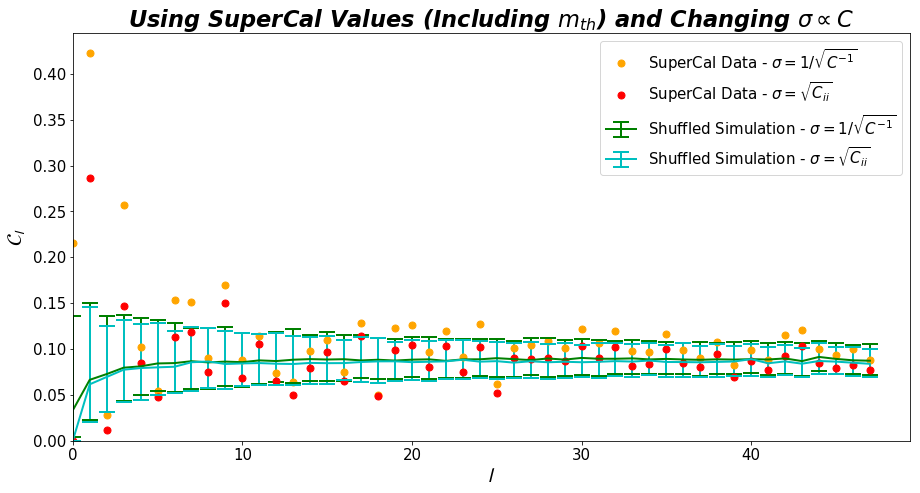

Chi^2 / DOF (1/sqrt(C^-1):
2.38151945142
Chi^2 / DOF (sqrt(C)):
1.0271616506
Chi^2 / DOF (Norm):
7.4422048579


In [51]:
plt.figure(figsize=(15,7.5))
#NSIDE=16
plt.plot(elld_inv, cld_inv, 'ko', color='orange', label='SuperCal Data - $\sigma = 1/\sqrt{C^{-1}}$', ms=7)

plt.errorbar(ells_inv, cls_inv, yerr= err_inv,
            fmt='-', ecolor='green', capsize=8, capthick=2, elinewidth=2, linewidth=2,
            color='green', label='Shuffled Simulation - $\sigma = 1/\sqrt{C^{-1}}$')

plt.plot(elld_cov, cld_cov, 'ko', color='r', label='SuperCal Data - $\sigma = \sqrt{C_{ii}}$', ms=7)

plt.errorbar(ells_cov, cls_cov, yerr= err_cov,
            fmt='-', ecolor='c', capsize=8, capthick=2, elinewidth=2, linewidth=2,
            color='c', label='Shuffled Simulation - $\sigma = \sqrt{C_{ii}}$')
'''
plt.plot(elld_nor, cld_nor, 'ko', color='magenta', label='SuperCal Data - $\sigma$ from SuperCal', ms=7)

plt.errorbar(ells_nor, cls_nor, yerr= err_nor,
            fmt='-', ecolor='purple', capsize=8, capthick=2, elinewidth=2, linewidth=2,
            color='purple', label='Shuffled Simulation - $\sigma$ from SuperCal')
'''

plt.xlabel('$\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.ylabel('$\mathcal{C}_\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.title('Using SuperCal Values (Including $m_{th}$) and Changing $\sigma \propto C$', 
          fontsize=22.5, style='italic', weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis(xmin=0, ymin=0)
plt.legend(loc='upper right', numpoints=1, fontsize=15)
plt.savefig("LotsOfStuff2.png")
plt.show()

ch_inv = f.chi_sq(np.array(cld_inv), np.array(cls_inv), np.array(err_inv))

print "Chi^2 / DOF (1/sqrt(C^-1):"
print ch_inv/max(ells_inv)

ch_cov = f.chi_sq(np.array(cld_cov), np.array(cls_cov), np.array(err_cov))
print "Chi^2 / DOF (sqrt(C)):"
print ch_cov/max(ells_cov)

ch_nor = f.chi_sq(np.array(cld_nor), np.array(cls_nor), np.array(err_nor))
print "Chi^2 / DOF (Norm):"
print ch_nor/max(ells_nor)

## Using $\sigma = \sqrt{C}$ diagonals

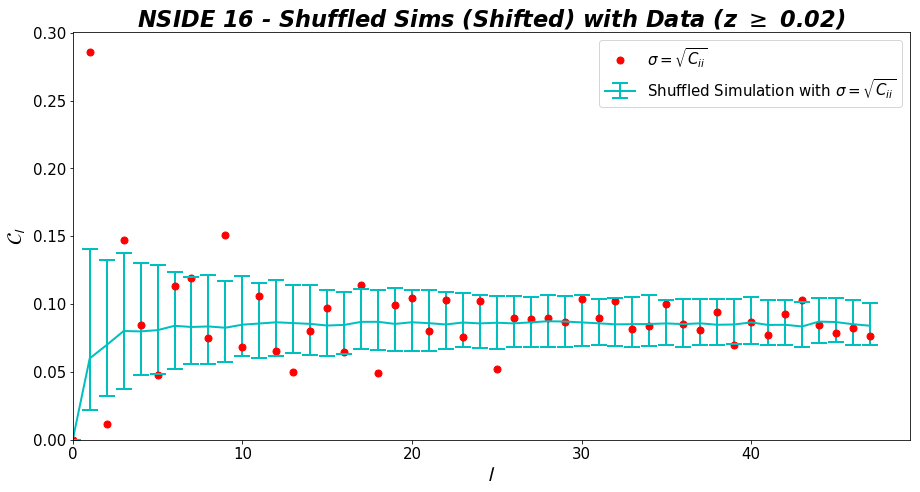

Chi^2 / DOF :
1.06563765808


In [22]:
plt.figure(figsize=(15,7.5))
#NSIDE=16
plt.plot(elld_cov, cld_cov, 'ko', color='r', label='$\sigma = \sqrt{C_{ii}}$', ms=7)

plt.errorbar(ells_cov, cls_cov, yerr= err_cov,
            fmt='-', ecolor='c', capsize=8, capthick=2, elinewidth=2, linewidth=2,
            color='c', label='Shuffled Simulation with $\sigma = \sqrt{C_{ii}}$')

plt.xlabel('$\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.ylabel('$\mathcal{C}_\mathcal{l}$', fontsize=20, style = 'normal', weight='bold')
plt.title('NSIDE 16 - Shuffled Sims (Shifted) with Data (z $\geq$ 0.02)', 
          fontsize=22.5, style='italic', weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis(xmin=0, ymin=0)
plt.legend(loc='upper right', numpoints=1, fontsize=15)
plt.show()

ch_cov = f.chi_sq(np.array(cld_cov), np.array(cls_cov), np.array(err_cov))

print "Chi^2 / DOF :"
print ch_cov/max(ells_cov)

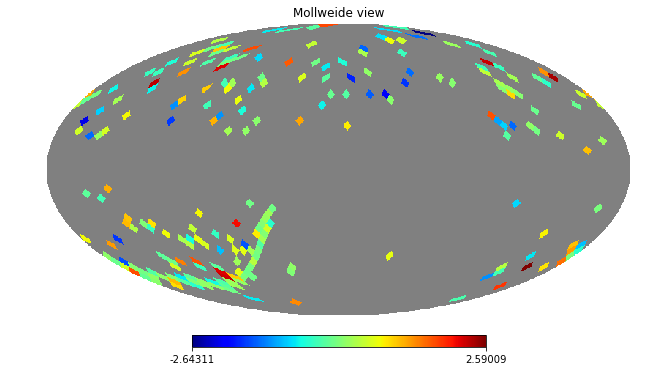

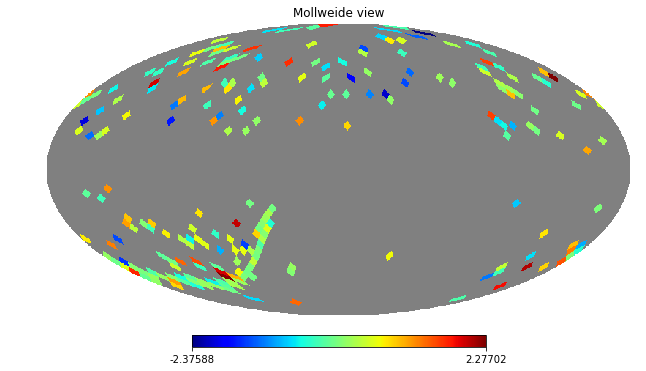

In [16]:
pix_resd_inv = f.pixres(16, theta, phi, resd_inv)
pix_resd_cov = f.pixres(16, theta, phi, resd_cov)

hp.mollview(pix_resd_inv)
hp.mollview(pix_resd_cov)

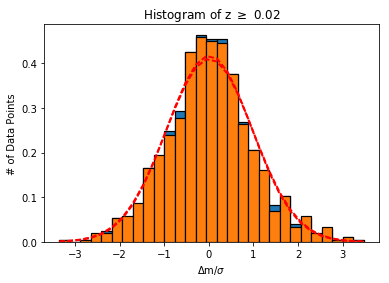

In [20]:
arr_cov = np.array(resd_cov)

(mu, sigma) = norm.fit(arr_cov)
n_cov, bins, patches = plt.hist(arr_cov, bins='auto', edgecolor='black', linewidth=1.2, normed=True)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.title("Histogram of z $\geq$ 0.02")
plt.xlabel("$\Delta$m/$\sigma$")
plt.ylabel("# of Data Points")

arr_inv = np.array(resd_inv)

(mu, sigma) = norm.fit(arr_inv)
n_inv, bins, patches = plt.hist(arr_inv, bins='auto', edgecolor='black', linewidth=1.2, normed=True)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.title("Histogram of z $\geq$ 0.02")
plt.xlabel("$\Delta$m/$\sigma$")
plt.ylabel("# of Data Points")
plt.show()


#plt.show()

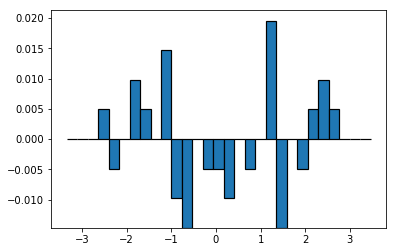

In [89]:
n_dif = n_inv - n_cov
x_loc = np.zeros(np.size(bins) - 1)

for i in range(np.size(bins) - 1):
    x_loc[i] = (bins[i] + bins[i+1]) / 2

plt.bar(x_loc, n_dif, width = (bins[1]-bins[0]), linewidth = 1.2, edgecolor = 'black')
plt.show()